# **Imports and importing the data**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

rateMyProfData = pd.read_csv('Cleaned_UW_RMP.csv')


In [2]:
rateMyProfData.head()

,Review-Body,Date,Course-Name,Course-Number,For-Credit,Attendance,Take-Again,Grade,Textbook,Quality,Difficulty
0,"It's not hard class, but don't expect the 4.0....",2015-03-08,BUS,340.0,Yes,NaN,NaN,NaN,Yes,2.0,2.0
1,Syllabus was clear on what the daily homework ...,2016-02-21,BCUSP,202.0,Yes,NaN,NaN,NaN,Yes,2.5,3.0
2,Bridge is the coolest prof I've ever had. His ...,2023-11-20,BME,221.0,Yes,Not Mandatory,Yes,NaN,Yes,5.0,2.0
3,Bridge makes it abundantly clear what you need...,2020-08-22,ME,341.0,Yes,Not Mandatory,Yes,NaN,Yes,5.0,3.0
4,One of the best professors I have ever had. Tr...,2020-04-22,BENGR,321.0,Yes,Mandatory,Yes,NaN,Yes,5.0,3.0


# **Data Analysis**

## **Further Data Checking and Cleaning**

In [4]:
# See the null values by each row
rateMyProfData.isnull().sum()

Review-Body        1
Date               0
Course-Name       83
Course-Number    522
Quality            0
Difficulty         0
dtype: int64

In the above cell, we can see there are a significant number of null values in the columns that are optional for users when leaving a review. Due to the sheer number of null values, This information is not neccessary or useful. We will drop these for the rest of our analysis.

In [3]:
rateMyProfData.drop(columns=['For-Credit', 
                         'Attendance', 
                         'Take-Again', 
                         'Grade', 
                         'Textbook'], inplace=True)

Further we need to deal with the null values that are still in place. For the review body, there is only one null value, and the review body is necessary so we will drop this row.

In [6]:
rateMyProfData = rateMyProfData.dropna(subset=['Review-Body'])

** MAYBE DROP THE COURSE NAME/NUMBER OR DROP THE ROWS WITH NULLS WE NEED TO DECIDE THIS**

In [1]:
### rateMyProfData = rateMyProfData.dropna(subset=['Course-Name', 'Course-Number'])
##  rateMyProfData['Course-Number'] = [str(num)[0] for num in rateMyProfData['Course-Number']] # user input data is all over the place, 
#   take the first digit for the class year, ie 1 = 100 level, 4 = 400 level.
#
#   PICK ONE
##
### rateMyProfData.drop(columns=['Course-Name', 'Course-Number'], inplace=True)

## **Data Analysis**

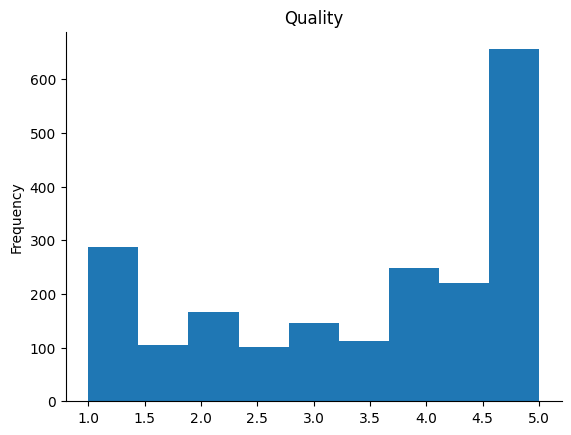

In [3]:
rateMyProfData['Quality'].plot(kind='hist', bins=9, title='Quality')
plt.gca().spines[['top', 'right',]].set_visible(False)

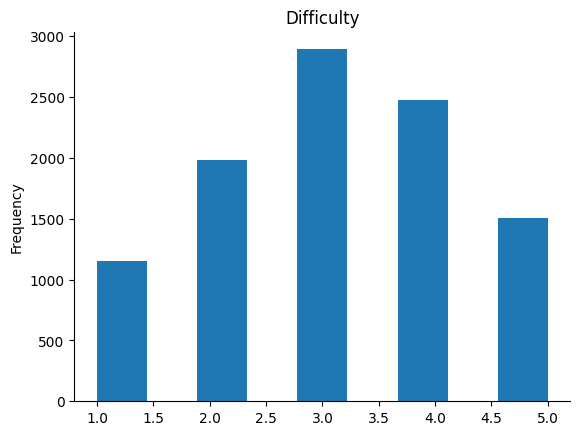

In [4]:
rateMyProfData['Difficulty'].plot(kind='hist', bins=9, title='Difficulty')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# rateMyProfData['Course-Number'].value_counts().plot(kind='bar')
# plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# for i, course_number in enumerate([1, 2, 3, 4]):
#   ax = axes[i // 2, i % 2]
#   course_data = rateMyProfData[rateMyProfData['Course-Number'] == str(course_number)]
#   course_data['Quality'].plot(kind='hist', bins=9, title=f'Quality Distribution for {course_number}00 level courses', ax=ax)
#   ax.spines[['top', 'right']].set_visible(False)

# plt.tight_layout()

In [ ]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# for i, course_number in enumerate([1, 2, 3, 4]):
#   ax = axes[i // 2, i % 2]
#   course_data = rateMyProfData[rateMyProfData['Course-Number'] == str(course_number)]
#   course_data['Difficulty'].plot(kind='hist', bins=5, title=f'Difficulty Distribution for {course_number}00 level courses', ax=ax, width=0.6)
#   ax.spines[['top', 'right']].set_visible(False)

# plt.tight_layout()

In [ ]:
# course_counts = rateMyProfData['Course-Name'].value_counts()
# for course_name, count in course_counts.items():
#   if count > 100:
#     print(f"{course_name}: {count}")

In [ ]:
# fig, axes = plt.subplots(3, 3, figsize=(12, 10))

# for i, course_name in enumerate(course_counts.index[:9]):
#   ax = axes[i // 3, i % 3]
#   course_data = rateMyProfData[rateMyProfData['Course-Name'] == course_name]
#   course_data['Quality'].plot(kind='hist', bins=9, title=course_name, ax=ax)
#   ax.spines[['top', 'right']].set_visible(False)

# plt.tight_layout()

Possible analysis with Course name, number, date, etc.

## **Prediction of Quality and Difficulty**